# Bài thực hành: Phân vùng ngữ nghĩa
Trong bài này ta sẽ xây dựng mô hình phân vùng polyp trong ảnh nội soi với kiến trúc mạng UNet

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch.nn as nn
import numpy as np
from torchsummary import summary
import albumentations
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf

### Chuẩn bị tập dữ liệu cho bài toán phân vùng polyp trong ảnh nội soi, dữ liệu bao gồm 612 cặp ảnh nội soi và nhãn tương ứng, được chia thành 550 cặp để train và 62 cặp để test, ảnh được resize về kích thước 352x352  
**TẢI DỮ LIỆU TẠI LINK SAU**: <a href="https://drive.google.com/file/d/12AQ4qz6PjAe16-WUBxuP9cHVZ7EmgoxO/view?usp=sharing"> https://drive.google.com/file/d/12AQ4qz6PjAe16-WUBxuP9cHVZ7EmgoxO/view?usp=sharing </a>


Tăng cường dữ liệu bằng cách sử dụng các phép xoay ảnh, lật ảnh, thay đổi độ sáng, độ tương phản bằng thư viện albumentation. Link: [https://github.com/albumentations-team/albumentations](https://github.com/albumentations-team/albumentations/)

In [ ]:
train_transform = Compose([
        transforms.Rotate(p=0.8),
        transforms.Flip(),
        transforms.RandomBrightnessContrast(),
        transforms.Resize(352,352)
])

test_transform = Compose([
        transforms.Resize(352, 352)
])

Tạo dataset cho polyp, bao gồm tập các cặp ảnh gốc - nhãn tương ứng

In [ ]:
class PolypDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.list_img_paths = os.listdir(img_paths)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_paths, self.list_img_paths[idx])
        mask_path = img_path.replace('image', 'mask')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)

        #thực hiện augment cho ảnh đầu vào và nhãn tương ứng 
        ### YOUR CODE HERE ###


        ### YOUR CODE HERE ###
        
        image = image.astype('float32') / 255
        image = image.transpose((2, 0, 1))

        mask = mask[:,:,np.newaxis]
        mask = mask.astype('float32') / 255
        mask = np.round_(mask)
        mask = mask.transpose((2, 0, 1))

        return image, mask

Tạo DataLoader cho tập dữ liệu

In [ ]:
batch_size = 8
train_img_paths = '/content/drive/MyDrive/segmentation/dataset/clinic_train/image'
test_img_paths  = '/content/drive/MyDrive/segmentation/dataset/clinic_test/image'

train_dataset = PolypDataset(train_img_paths, transform = train_transform)
test_dataset  = PolypDataset(test_img_paths, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle=False, pin_memory=True, drop_last=False)

Visualize ảnh đầu vào

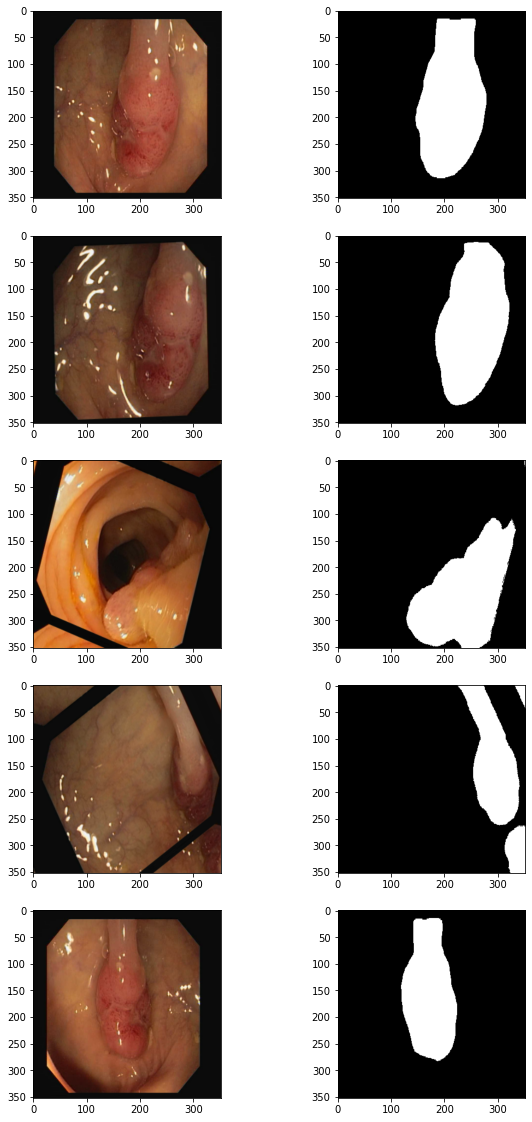

In [ ]:
#visualize ảnh từ tập dữ liệu
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 20))
for i in range(1, 6):
    ### lấy ảnh từ tập dữ liệu và chuyển lại về dạng RGB
    img, mask = train_dataset[i]
    img = img.transpose((1, 2, 0))
    mask = mask.transpose((1, 2, 0))

    fig.add_subplot(5, 2, 2*i - 1)
    plt.imshow(img)

    fig.add_subplot(5, 2, 2*i)
    plt.imshow(mask.squeeze(axis=-1), cmap='gray')
plt.show()

### Xây dựng mô hình UNet

Xây dựng một khối tích chập cơ bản của UNet, bao gồm 2 lớp conv, batch norm, relu kế tiếp nhau

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.rl1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.rl2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl2(x)

        return x

Xây dựng một khối của phần mã hóa, bao gồm một khối tích chập theo sau một hàm downsample

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x):
        # viết hàm forward cho khối mã hóa với đầu vào là feature map x
        ### YOUR CODE HERE

        ### YOUR CODE HERE

Một khối của phần giải mã, bao gồm một khối tích chập theo sau một hàm upsample

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_dec_channels, in_enc_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_dec_channels, in_dec_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_dec_channels // 2 + in_enc_channels, out_channels)
        
    def forward(self, x1, x2):
        # viết hàm forward cho khối giải mã với đầu vào:
        # x1: feature map từ khối giải mã trước đó
        # x2: feature map từ khối mã hóa
        ### YOUR CODE HERE

        ### YOUR CODE HERE

Xây dựng mô hình UNet với sự kết hợp giữ phần mã hóa và phần giải mã

In [ ]:
class UNet(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.enc_1 = ConvBlock(3, channels)
        self.enc_2 = EncoderBlock(channels, channels*2)
        self.enc_3 = EncoderBlock(channels*2, channels*4)
        self.enc_4 = EncoderBlock(channels*4, channels*8)
        self.enc_5 = EncoderBlock(channels*8, channels*16)

        self.dec_1 = DecoderBlock(channels*16, channels*8, channels*8)
        self.dec_2 = DecoderBlock(channels*8, channels*4, channels*4)
        self.dec_3 = DecoderBlock(channels*4, channels*2, channels*2)
        self.dec_4 = DecoderBlock(channels*2, channels, channels)
        self.conv_out = nn.Conv2d(channels, 1, kernel_size=1)
    def forward(self, x):
        enc_1 = self.enc_1(x)
        enc_2 = self.enc_2(enc_1) 
        enc_3 = self.enc_3(enc_2)
        enc_4 = self.enc_4(enc_3)
        enc_5 = self.enc_5(enc_4)

        dec_1 = self.dec_1(enc_5, enc_4)
        dec_2 = self.dec_2(dec_1, enc_3)
        dec_3 = self.dec_3(dec_2, enc_2)
        dec_4 = self.dec_4(dec_3, enc_1)
        out = self.conv_out(dec_4)
        return out

In [ ]:
model = UNet(channels=64).cuda()

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         ConvBlock-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

### Hàm huấn luyện mô hình

In [ ]:
def train(model, train_loader, criterion, optimizer, epoch, epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        # lấy ra cặp ảnh nội soi - nhãn, đưa ra dự đoán và tính hàm loss
        ### YOUR CODE HERE 
        

        ### YOUR CODE HERE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print('Epoch {}/{}: Loss {:.5f}'.format(epoch+1, epochs, total_loss / len(train_loader)))
    return total_loss / len(train_loader) 

### Hàm đánh giá mô hình, dựa trên các chỉ số **Dice** và **IOU**

In [ ]:
from keras import backend as K
def recall_np(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_np(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_np(y_true, y_pred):
    precision = precision_np(y_true, y_pred)
    recall = recall_np(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou_np(y_true, y_pred):
    intersection = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    union = np.sum(y_true)+np.sum(y_pred)-intersection
    return intersection/(union+K.epsilon())

def inference(model, test_loader, epoch, epochs):
    model.eval()
    mean_dice = 0
    mean_iou = 0
    for i, batch in enumerate(test_loader, start=1):
        image, mask = batch
        mask = mask[0][0]
        mask = np.asarray(mask, np.float32)
        image = image.cuda()

        pred = model(image)
        pred = pred.sigmoid().data.cpu().numpy().squeeze()
        pred = pred.round()
        mean_dice += dice_np(mask, pred)
        mean_iou += iou_np(mask, pred)
    mean_dice = mean_dice / len(test_loader)
    mean_iou = mean_iou / len(test_loader)
    print('Epoch {}/{}: Mean Dice {:.4f} Mean IOU {:.4f}'.format(epoch+1, epochs, mean_dice, mean_iou))

Khởi tạo các giá trị:
1.   Số lượng epochs
2.   Learning rate khởi tạo
3.   Optimizer: Adam
4.   Loss function: Binary Cross Entropy

và huấn luyện, đánh giá mô hình



In [ ]:
epochs = 5
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCEWithLogitsLoss().cuda()

for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, epoch, epochs)
    inference(model, test_loader, epoch, epochs)
    print()